<a href="https://colab.research.google.com/github/alzimna/Portfolio/blob/main/Product%20Detection/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Overview**

Seringkali kita ingin mengetahui nama dari suatu produk melalui fotonya. Dewasa ini, sudah banyak model AI yang dilatih untuk mendeteksi nama-nama produk melalui gambar atau video seperti YOLO, Faster R-CNN, RetinaNet, EfficientDet, dan lain-lain.

Pada Notebook ini kita akan mencoba membuat program untuk mengklasifikasikan gambar-gambar dari suatu produk fashion dan menggolongkannya ke dalam kelas Pria dan Wanita hanya dengan menggunakan algoritma linear classification. Tujuan dari projek ini adalah untuk mengungkap peran matematika di balik penggunaan Linear classification dan menyajikannya ke dalam program siap pakai.

Setelah melakukan klasifikasi pada data gambar yang kita punya, kita juga akan melihat penerapan algoritma klasifikasi lainnya yaitu KNN untuk menampilkan 5 barang yang mempunyai karakteristik serupa dengan produk yang kita inginkan. Sekali lagi, model pada notebook ini dibangun berdasarkan formula matematika yang melatarbelakanginya.

# **Project Method**
Metode yang digunakan adalah klasifikasi linear dan KNN yang ada pada Bab 9 buku "Method of Multivariate Analysis" oleh  ALVIN C. RENCHER. Pada dasarnya saya akan mengimplementasikan teori yang disajikan pada buku tersebut ke dalam script Python.

# **Code Snippet**

In [1]:
import numpy as np
import pandas as pd
import scipy
import os
import math
import cv2
import shutil
import requests, zipfile, io
from PIL import Image
from skimage import feature, color, data
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from IPython.display import clear_output


def accuracy_rate(df) :
  trace = df.to_numpy().trace()
  total = df.to_numpy().sum()
  return(trace/total)

def hog_data_extractor(jpeg_path):
    jpeg_data = cv2.imread(jpeg_path,cv2.IMREAD_GRAYSCALE)
    jpeg_data=cv2.resize(jpeg_data,(80,60))
    hog_data = feature.hog(jpeg_data)/255.0
    return hog_data

In [2]:
url = "https://github.com/alzimna/Portfolio/raw/refs/heads/main/Product%20Detection/kontekstual.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Langkah pertama adalah mengubah gambar menjadi array dengan setiap entri ke-i menyatakan seberapa cerah pixel ke-i. Tujuan dari langkah ini agar data yang berbentuk gambar dapat diolah secara matematis.

Pada awalnya terdapat dua folder yang kita punya yaitu pria dan wanita yang menunjukkan preferensi gender dari produk di dalam masing-masing file. Setiap kelas akan dibagi menjadi data train dan data test sehingga menghasilkan 4 folder yaitu pria_train, pria_test, wanita_train, dan wanita_test

In [3]:
gender = ["pria","wanita"]
X_train = []
X_test = []

def to_array (kelas,gender_type):
    gender_path = 'kontekstual/'+gender_type.lower()+'_'+kelas
    print('Loading images for gender type '+gender_type+'_'+kelas)
    if kelas=="train" :
      X = X_train
    else :
      X = X_test
    for img in os.listdir(gender_path):
        img_path = os.path.join(gender_path,img)
        X.append(hog_data_extractor(img_path))
[to_array("train",gender_type) for gender_type in gender]
[to_array("test",gender_type) for gender_type in gender]
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

Loading images for gender type pria_train
Loading images for gender type wanita_train
Loading images for gender type pria_test
Loading images for gender type wanita_test


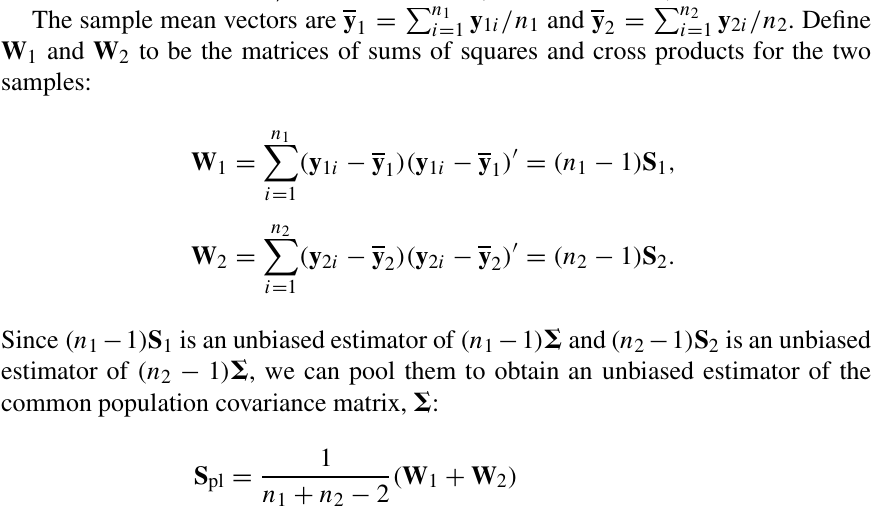

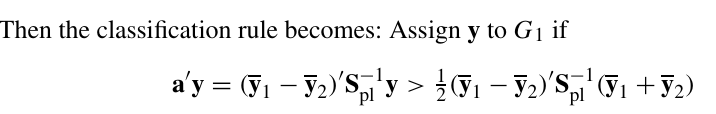

In [4]:
y1_bar = X_train.iloc[:3500,:].mean().values
y2_bar = X_train.iloc[3500:,:].mean().values
S1 = pd.DataFrame.cov(X_train.iloc[:3500,:]).values
S2 = pd.DataFrame.cov(X_train.iloc[3500:,:]).values
S_pl = 1/(7000-2)*((3500-1)*S1+(3500-1)*S2)

Untuk mencari classification rule dari data yang dimiliki, digunakan rumus berikut

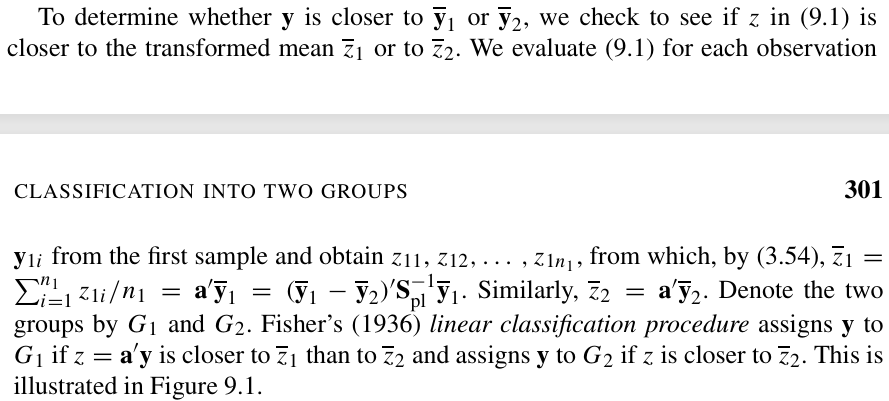

In [5]:
a = np.matmul(np.linalg.inv(S_pl),(y1_bar-y2_bar))
z1_bar = np.matmul(a,y1_bar)
z2_bar = np.matmul(a,y2_bar)
z_batas = 1/2*(z1_bar+z2_bar)

Dengan demikian apabila nilai z lebih dari z_batas maka gambar tersebut akan digolongkan sebagai pria dan sebaliknya jika z kurang dari z_batas maka akan digolongkan sebagai wanita

Selanjutnya dilakukan klasifikasi pada data yang dimiliki, mula-mula akan dicoba pada data train dan selanjutnya menggunakan data test

In [6]:
n_11 = 0
n_12 = 0
n_21 = 0
n_22 = 0
for i in range(7000) :
  if i<3500 :
    y = X_train.iloc[i,:]
    z = np.matmul(a,y)
    if z > z_batas :
      n_11+=1
    else :
      n_12+=1
  else :
    y = X_train.iloc[i,:]
    z = np.matmul(a,y)
    if z > z_batas :
      n_21+=1
    else :
      n_22+=1
#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi Linear Classification (train)")
d = {'1': [n_11, n_21], '2': [n_12, n_22]}
df = pd.DataFrame(data=d,index = [1,2])
print(df)
acc_train_linear = accuracy_rate(df)
print("Accuracy rate train linear= ",acc_train_linear)

Tabel klasifikasi Linear Classification (train)
      1     2
1  3498     2
2     0  3500
Accuracy rate train linear=  0.9997142857142857


Dari sini diperoleh bahwa dengan z_batas yang diperoleh dengan menggunakan data train, akan menghasilkan 3498 produk pria yang diprediksi sebagai produk pria dan 2 produk pria akan dikenali sebagai produk wanita. Di lain sisi, tepat 3500 produk wanita sesuai dengan kelasnya

In [7]:
p_11 = 0
p_12 = 0
p_21 = 0
p_22 = 0
for i in range(1750) :
  if i<875 :
    y = X_test.iloc[i,:]
    z = np.matmul(a,y)
    if z > z_batas :
      p_11+=1
    else :
      p_12+=1
  else :
    y = X_test.iloc[i,:]
    z = np.matmul(a,y)
    if z > z_batas :
      p_21+=1
    else :
      p_22+=1
#Membuat tabel hasil klasifikasi
print("Tabel klasifikasi Linear Classification (test)")
d = {'1': [p_11, p_21], '2': [p_12, p_22]}
df = pd.DataFrame(data=d,index = [1,2])
print(df)
acc_test_linear = accuracy_rate(df)
print("Accuracy rate test = ",acc_test_linear)

Tabel klasifikasi Linear Classification (test)
     1    2
1  838   37
2   31  844
Accuracy rate test =  0.9611428571428572


Dari sini diperoleh bahwa dengan z_batas yang diperoleh dengan menggunakan data train, pada data test akan menghasilkan 839 produk pria yang diprediksi sebagai produk pria dan 36 lainnya akan dikenali sebagai produk wanita. Di lain sisi, 30 produk wanita akan dikenali sebagai produk pria dan 845 sisanya digolongkan sesuai dengan kelasnya

Berikut ini diberikan ilustrasi apabila data yang dimasukkan berupa gambar, bisa juga digunakan data dari luar data yang digunakan pada notebook ini

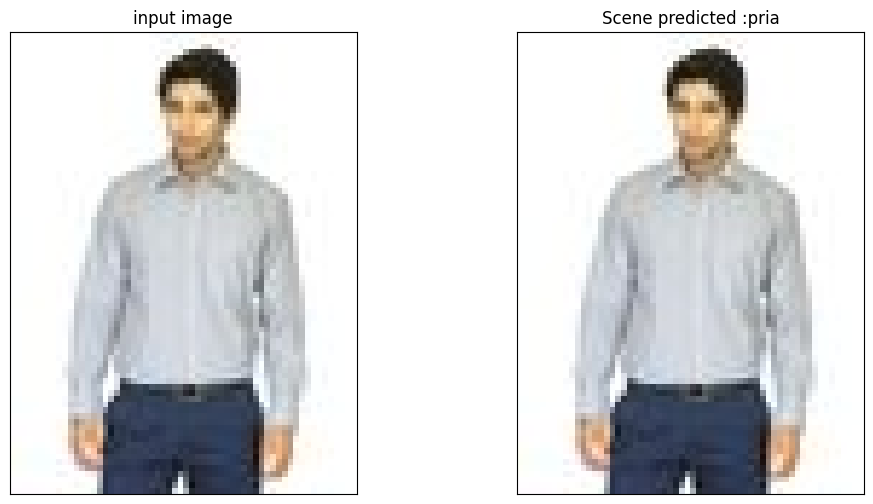

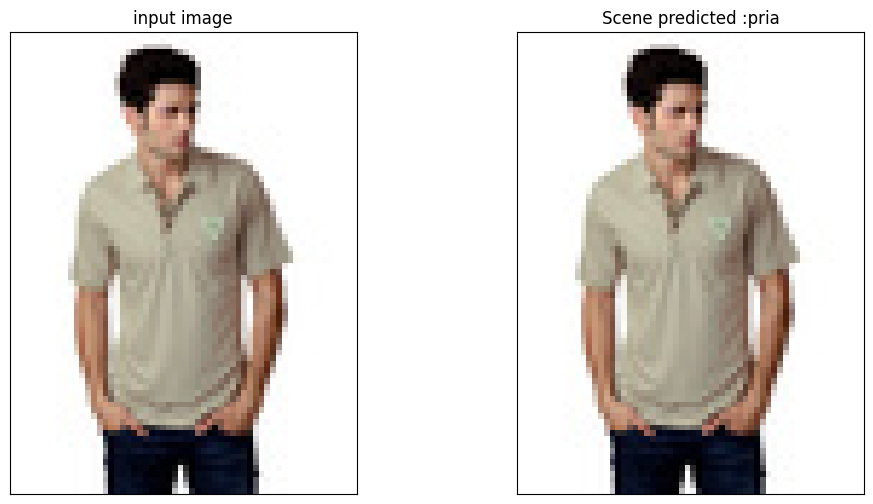

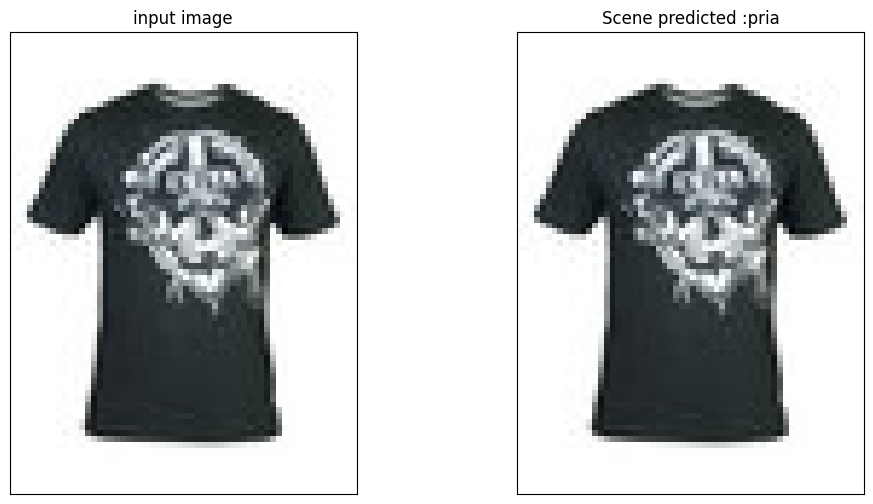

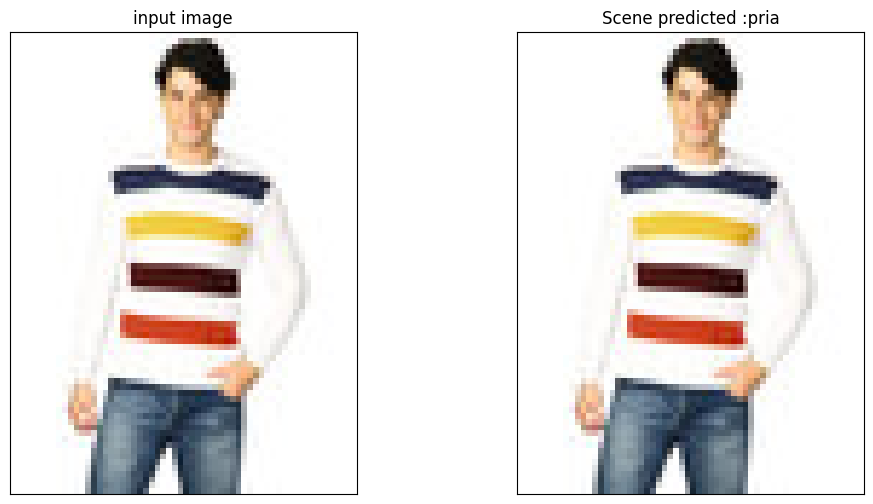

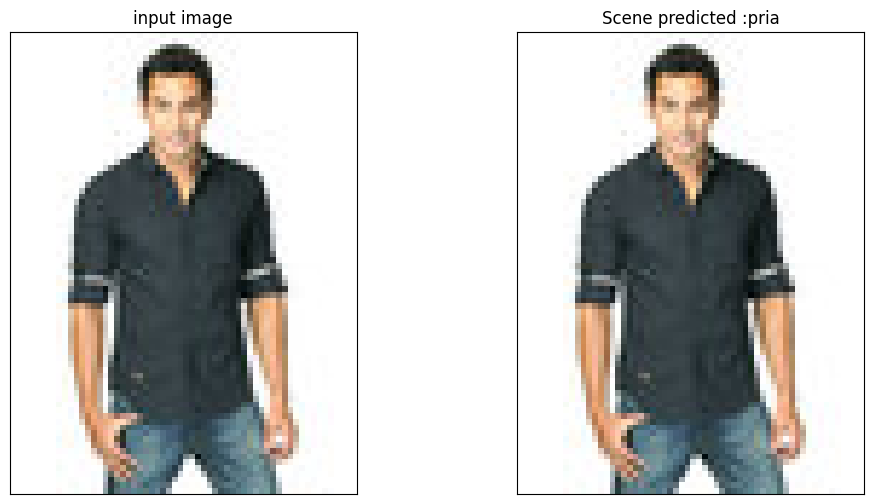

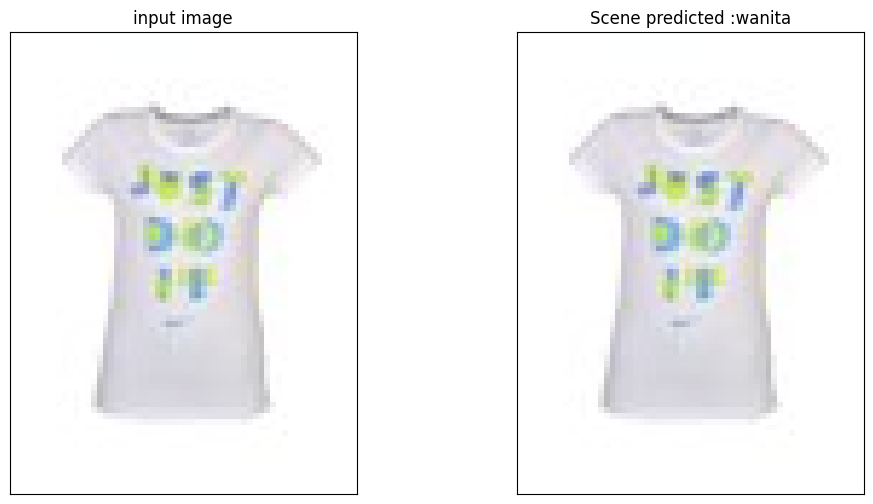

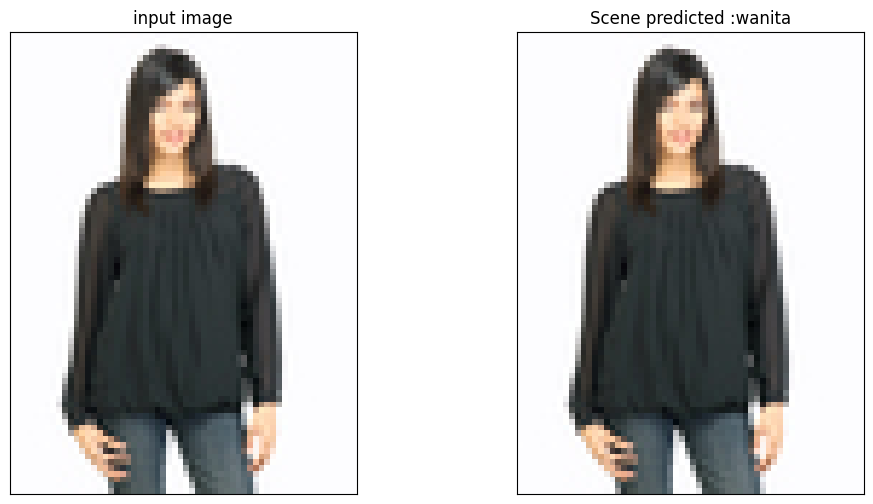

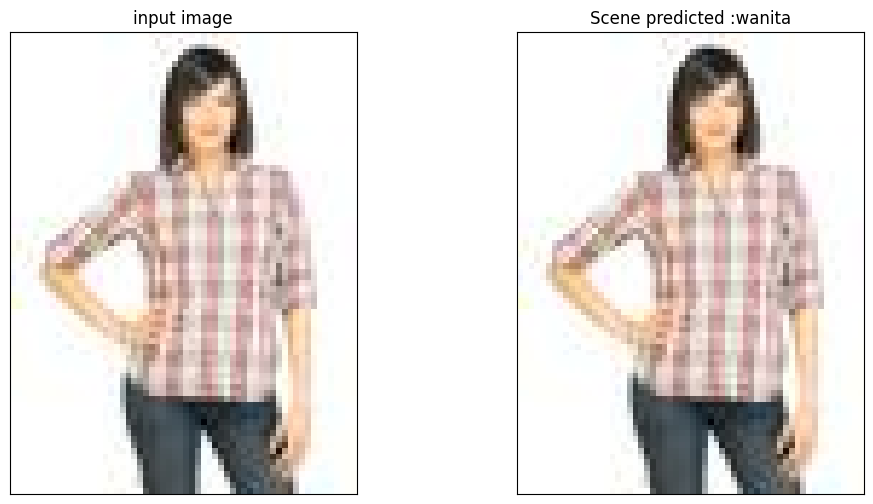

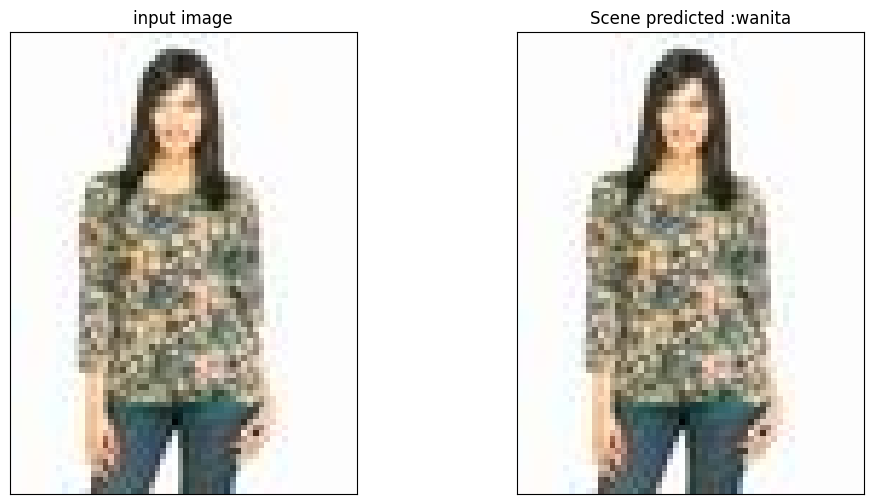

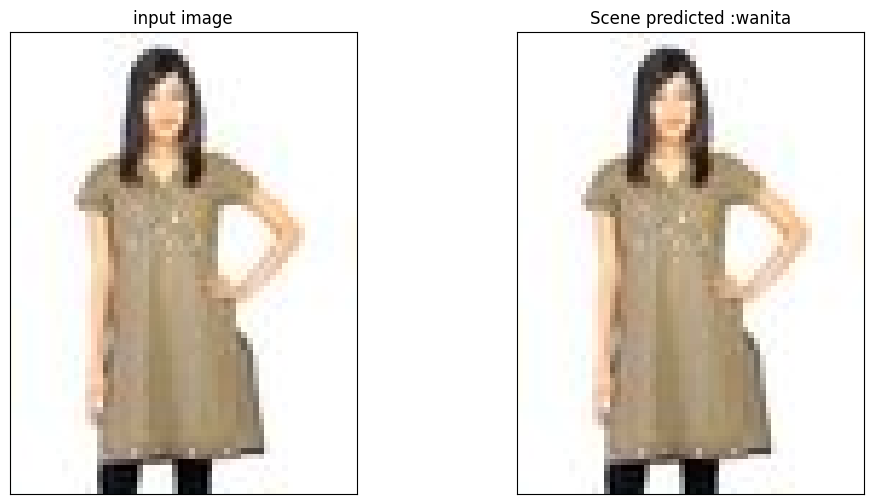

In [8]:
def scene_predict(img_path):
  image = cv2.imread(img_path)
  ip_image = Image.open(img_path)
  y = hog_data_extractor(img_path)
  z = np.matmul(a,y)
  if z > z_batas :
    gender_predicted = 'pria'
  else :
    gender_predicted = 'wanita'
  fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw=dict(xticks=[], yticks=[]))
  ax[0].imshow(ip_image)
  ax[0].set_title('input image')

  ax[1].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
  ax[1].set_title('Scene predicted :'+ gender_predicted)

for item in gender :
    img_path = 'kontekstual/'+item+'_test'
    l = os.listdir(img_path)
    for i in range(5) :
      scene_predict(img_path+"/"+l[i])

Seringkali pembeli mencoba untuk mencari produk yang serupa dengan produk yang dilihatnya sekarang. Berikut ini diberikan algoritma yang dapat memunculkan beberapa produk yang serupa dari suatu input gambar. Dengan menggunakan algoritma sederhana seperti KNN sudah diperoleh hasil yang memuaskan.

In [9]:
def samain(file) :
  if file in os.listdir('kontekstual/pria_test') :
    img_path ='kontekstual/pria_test/'+file
  else :
    img_path ='kontekstual/wanita_test/'+file
  image = cv2.imread(img_path)
  ip_image = Image.open(img_path)
  fig, ax = plt.subplots(1,1 , figsize=(12, 6),
                          subplot_kw=dict(xticks=[], yticks=[]))
  ax.imshow(ip_image)
  ax.set_title('Barang yang akan dibeli')
  Y = np.asmatrix(X_train)
  y = hog_data_extractor(img_path)
  S=np.linalg.inv(S_pl)
  distance = []
  for k in range(7000) :
    d = float((y-Y[k]) @ S @ np.transpose((y-Y[k])))
    distance.append(d)
    clear_output(wait=True)
    print(k,"/",7000)
  id = np.array(distance).argsort()[1:6]
  l = os.listdir('kontekstual/pria_train')
  l = l+os.listdir('kontekstual/wanita_train')
  ip_image = dict()
  for i in range(5) :
    nama = l[id[i]]
    if id[i]<3500 :
      img_path ='kontekstual/pria_train/'+nama
    else :
      img_path ='kontekstual/wanita_train/'+nama
    image = cv2.imread(img_path)
    ip_image[i] = Image.open(img_path)
  fig, ax = plt.subplots(1, 5, figsize=(12, 6),
                          subplot_kw=dict(xticks=[], yticks=[]))
  for j in range(5):
    ax[j].imshow(ip_image[j])
    ax[j].set_title('barang yang sama '+str(j+1))

In [ ]:
samain('10022.jpg')

1629 / 7000


In [ ]:
samain('10342.jpg')